In [1]:
%load_ext jupyternotify
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from dedalus.extras import flow_tools
import time
import requests
from scipy.special import erf
from dedalus.core.operators import GeneralFunction
import pathlib
import subprocess
import h5py
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# Clean up any old files
import shutil
from datetime import datetime
import logging
shutil.rmtree('analysis', ignore_errors=True)


plt.rcParams['text.usetex'] = True

# ################################## Set fonts
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["cmss"],
#     "text.latex.preamble": r"\usepackage{sfmath}\renewcommand{\familydefault}{\sfdefault}",
# })


days = 24*60*60

########################################################################################
########################################################################################
### Set Parameters

Nx, Ny = 128, 128 # Resolution
tau_r = 2* days  # radiative relaxation timescale. "is of the order of a few days" VP2020 
tau_e = 2.4* days #evaporative timescale, analagous to lambda_, from VP reply
nu_ = 1*10**5.5# multiplied by 2 for nu_q, below
gamma =8 #  (L*H*Q_a)/ (q_0*c_p*T_0) # ~8.5 in VP2020, 5 in reply
alpha = 60 # L / (Rv*T_0) # ~20 in VP2020, 2 in reply

TIMESTEP_CAP = 0.8 # factor of tau for max timestep 
RUN_TIME = 30 # simulation stop time
##𝛼 = 60, 𝛾 = 15, 𝜏r = 2days, 𝜆= 0.08days−1, 𝛽= 2 ×10−11 m−1 ⋅ s−1 and a resolution of 20 km" Beta plane w/ active tracer, VP 2020

########################################################################################
########################################################################################
### Domain 
Lx = 1.0e7 
Ly = 1.0e7 
xmin, xmax = -Lx/2, Lx/2
ymin, ymax = -Ly/2, Ly/2
f0 = 0
f_ = 4.0e-4 # For f-plane 
beta = 2.0e-11 # For beta plane 


### Simulation Parameters 
g = 10.0 #g
H = 30.0 #Mean height
tau = 900.0 #Condensation timescale
lambda_r = 1.1e-5 #lambda_r as written in VP reply
lambda_ =0.08/(60*60*24) #11*(60*60*24) #evaporation coefficient, "wit



# no velocity dependence the system becomes saturated within a few days."
h_0 = 0 #VP2020
q_0 = 1.0 # "Taken to be unity"
q_g = 1.0 # 
L = 2.4*10**6 # Latent heat of condensation
Q_a = 0.035 # Tropical surfaace saturated specific humidy
c_p = 1004 # c_p 
T_0 = 300 
Rv = 462 # Water vapor gas constant

nu_u =nu_ # Viscosities, VP 2020 #raised significantly per Keaton Burns  - defined above
nu_h =nu_
nu_q =2*nu_

/Users/luitbald/miniforge3/envs/dedalus3/lib/python3.12/site-packages/jupyternotify/jupyternotify.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


<IPython.core.display.Javascript object>

In [2]:
# Dedalus setup

coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype = np.float64)
x_basis = d3.RealFourier(coords['x'] , size = Nx, bounds = (xmin, xmax), dealias=3/2)
# y_basis = d3.RealFourier(coords['y'] , size = Ny, bounds = (ymin, ymax), dealias=3/2)
y_basis = d3.Chebyshev(coords['y'] , size = Ny, bounds = (ymin, ymax), dealias=3/2)
tau_basis = y_basis.derivative_basis(1)
x = dist.local_grid(x_basis)
y = dist.local_grid(y_basis)

U = dist.VectorField(coords, name='U', bases=(x_basis,y_basis))
h = dist.Field(name = 'h', bases = (x_basis, y_basis))
q = dist.Field(name = 'q', bases = (x_basis, y_basis))
f = dist.Field(name='f', bases=(y_basis))

# f['g'] = f_ # f-plane
f['g'] = f0 + beta*y  #beta plane

grad = lambda A: d3.Gradient(A)
lap = lambda A: d3.Laplacian(A)
div = lambda A: d3.Divergence(A)
dx = lambda A: d3.Differentiate(A, coords['x'])
dy = lambda A: d3.Differentiate(A, coords['y'])
zcross = lambda A: d3.Skew(A)
trace = lambda A: d3.Trace(A)
dot = lambda A,B: d3.DotProduct(A,B)

k_heaviside = 1e7

HeavisideTheta = lambda x: 0.5 + 0.5* erf(k_heaviside*x)
lift = lambda A: d3.Lift(A, tau_basis, -1)
norm = lambda A: np.sqrt(A@A)

In [3]:
#tau terms for rigid BCs

tau_Uy_1 = dist.VectorField(coords, name='tau_Uy_1', bases=(x_basis))
tau_Uy_2 = dist.VectorField(coords,name='tau_Uy_2', bases=(x_basis))

# tau_Ux_1 = dist.VectorField(coords,name='tau_Ux_1', bases=(x_basis,))
# tau_Ux_2 = dist.VectorField(coords,name='tau_Ux_2', bases=(x_basis,))

tau_h_1 = dist.Field(name='tau_h_1', bases=(x_basis, ))
tau_h_2 = dist.Field(name='tau_h_2', bases=(x_basis,))

tau_q_1 = dist.Field(name='tau_q_1', bases=(x_basis,))
tau_q_2 = dist.Field(name='tau_q_2', bases=(x_basis,))



In [4]:
# Initial Conditions

x = dist.local_grid(x_basis, scale = 1)
y = dist.local_grid(y_basis, scale= 1)

gaussian = lambda x,y,sigma: np.exp(-0.5*((x)**2 + (y)**2) / sigma**2)
h['g'] = 0.5*gaussian((x),(y),0.2*np.sqrt(Lx*Ly))# Gaussian bump

# U['g'][0] = Lx/(24*30*60*60)
# U['g'][1] = 0.0
# q['g'] +=0.2*gaussian(x,y,0.5*np.sqrt(Lx*Ly)) # Gaussian bump  
q['g'] =0.7*q_0 # background moisture near saturation   
# q['g'] = 0
# ### Random Noise 
# rng = np.random.default_rng(42)                
# h_noise = rng.normal(loc=0.0, scale=1.0, size=h['g'].shape).astype(h['g'].dtype)
# h['g'] += 0.05 * h_noise



In [ ]:

E = lambda A:  HeavisideTheta(q_g - A) * (q_g - A) / tau_e # /tau_e # No velocity-dependence
q_sat = lambda h_: q_0 * np.exp(-1*alpha * h_ / H) # Saturation specific humidity
C = lambda h_,q_: HeavisideTheta(q_-q_sat(h_))*(q_-q_sat(h_))/tau # condensation

problem = d3.IVP([U, h, q, tau_Uy_1, tau_Uy_2, tau_h_1, tau_h_2, tau_q_1, tau_q_2], namespace=locals()) 
# problem = d3.IVP([U, h, q], namespace=locals()) 

ex, ey = coords.unit_vector_fields(dist) 
U_x = U @ ex # x velocity component
U_y = U @ ey # y velocity component 
grad_u =d3.grad(U) + ey*lift(tau_Uy_1) # first-order reduction, U
grad_h = d3.grad(h) + ey*lift(tau_h_1) # first-order reduction, h
grad_q = d3.grad(q) + ey*lift(tau_q_1) # first-order reduction, q
u_dot_grad_q= d3.DotProduct(U, grad_q)  # not used
dy_Ux = d3.Differentiate(U_x, coords['y'])  # shear

### No advective terms

### beta plane
problem.add_equation("dt(U) + f*zcross(U) + g*grad_h + lift(tau_Uy_2)-nu_u*div(grad_u)=0")
problem.add_equation("dt(h) + H*trace(grad_u) -(h_0-h)/tau_r + lift(tau_h_2) - nu_h*div(grad_h) = -1*gamma*C(h,q)")
problem.add_equation("dt(q) + lift(tau_q_2) -nu_q*div(grad_q)  = E(q)-C(h,q) - q*trace(grad_u) - dot(U, grad_q)")
# problem.add_equation("dt(U) + f*zcross(U) + g*grad_h + lift(tau_Uy_2)= 0")
# problem.add_equation("dt(h) + H*trace(grad_u) -(h_0-h)/tau_r + lift(tau_h_2) = -1*gamma*C(h,q)")
# problem.add_equation("dt(q) + lift(tau_q_2)  = E(q)-C(h,q) - q*div(U) - dot(U, grad_q)")
### f-plane -- periodic boundaries 
# problem.add_equation("dt(U) + f*zcross(U) + g*grad(h) -nu_u*lap(lap(U))= 0")
# problem.add_equation("dt(h) + H*div(U) -(h_0-h)/tau_r  - nu_h*lap(lap(h)) = -gamma*C(h,q)")
# problem.add_equation("dt(q)  -nu_q*lap(lap(q))  = E(q)-C(h,q) - div(q*U)")
# ### Free-slip/rigid boundaries
problem.add_equation("(U_y)(y =-Ly/2)= 0")
problem.add_equation("(U_y)(y = Ly/2)= 0")
problem.add_equation("dy_Ux(y = -Ly/2) = 0")
problem.add_equation("dy_Ux(y =Ly/2)= 0")
problem.add_equation("dy(h)(y=Ly/2)=0")
problem.add_equation("dy(h)(y=-Ly/2)=0")
problem.add_equation("dy(q)(y=Ly/2)=0")
problem.add_equation("dy(q)(y=-Ly/2)=0")

solver = problem.build_solver('SBDF3') 
# solver.print_subproblem_ranks()



2025-12-01 14:22:42,905 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.6e+01/s
2025-12-01 14:22:43,139 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 2.4e+01/s
2025-12-01 14:22:43,471 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 2.2e+01/s
2025-12-01 14:22:43,795 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 1s, Remaining: 2s, Rate: 2.2e+01/s
2025-12-01 14:22:44,074 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 1s, Remaining: 2s, Rate: 2.3e+01/s
2025-12-01 14:22:44,370 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 2s, Remaining: 1s, Rate: 2.3e+01/s
2025-12-01 14:22:44,644 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 2s, Remaining: 1s, Rate: 2.3e+01/s
2025-12-01 14:22:44,920 subsystems 0/1 INFO :: Building subproblem matri

In [6]:

u_list = []
h_list = []
t_list = []
C_list = []
E_list = []
q_list = []

ux_s  = []
uy_s  = []
h_s  = []
q_s  = []

init_timestep = 0.1

KE = []
PE_g = []
PE_q = []

# kinetic_energy = lambda U,h: d3.Integrate(d3.Integrate(U@U*0.5*h, 'x'), 'y')/(Lx*Ly) #Kinetic energy per m^2
# potential_energy = lambda g,h: d3.integIntegraterate(d3.Integrate(0.5*g*h**2, 'y'), 'x')/(Lx*Ly) 
# moist_potential = lambda: d3.Integrate(d3.Integrate(gamma*q*h, 'y'), 'x')/(Lx*Ly) 

kinetic_energy = lambda h,u: d3.Integrate(d3.Integrate(0.5 * h * u@u,'x'),'y') / ((xmax-xmin)*(ymax-ymin))
potential_energy = lambda h:  d3.Integrate(d3.Integrate(0.5 * g * h**2,'x'),'y') / ((xmax-xmin)*(ymax-ymin))


In [7]:
%%notify -m "SIMULATION COMPLETE -- making animation... "
import os
#get date and time for filename
import datetime
from datetime import datetime
short_datetime = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
import logging
logger = logging.getLogger(__name__)


path = f'/Users/luitbald/CODE/movies/MJO_{short_datetime}'
os.mkdir(path)

with open(path+'/params.txt', 'w') as file:
    file.write(f"dt limit = {TIMESTEP_CAP*tau}s\n")
    file.write(f"Nx = {Nx}\n")
    file.write(f"Ny = {Ny}\n")
    file.write(f"tau = {tau}\n")
    file.write(f"tau_r = {tau_r}\n")
    file.write(f"tau_e = {tau_e}\n")
    file.write(f"q_0, g_g = {q_0}, {q_g}\n")
    file.write(f"gamma = {gamma}\n")
    file.write(f"alpha = {alpha}\n")
    file.write(f"nu_u, nu_h, nu_q = {nu_u}, {nu_h}, {nu_q}\n")
    file.write(f'\n\n Initial Conditions:\n')
    file.write(In[4])


#simulation time- stopped if blow-up occurs
solver.stop_sim_time = 24*60*60*RUN_TIME

#Analysis
filename = path+ f'/MJO_{alpha}a{gamma}g{Ny}r{nu_u}nu{tau_r}tr{tau_e}te' 
analysis = solver.evaluator.add_file_handler(f'{filename}', iter=10, max_writes=400)
analysis.add_tasks(solver.state, layout='g')
analysis.add_task(C(h,q), layout='g', name='C')

CFL = flow_tools.CFL(solver, initial_dt=init_timestep, cadence=10, safety=0.3, max_change=1.5)

CFL.add_velocity(U) 

logger.info('Starting loop')
start_time = time.time()
while solver.proceed:
    timestep = np.minimum(CFL.compute_timestep(), tau*TIMESTEP_CAP) #minimum of CFL condition, factor of condensation timescale 
    # timestep = CFL.compute_timestep()
    # tau = timestep
    solver.step(timestep)
    # #Save data every 10th iteration
    t_list.append(solver.sim_time)
    #     # u_list.append(np.copy(U['g'][0]))
    h_list.append(np.copy(h['g']))
    q_list.append(np.copy(q['g']))
    C_list.append(np.copy(C(h,q)['g']))
    KE.append(np.sum((U['g'][0]**2 + U['g'][1]**2)*0.5))
    PE_g.append(np.sum(g*h['g']))
    PE_q.append(np.sum((q['g']-q_sat(h)['g'])*gamma*g))

    #     # q_list.append(np.copy(q['g']))
    #     # q_sat_list.append(np.copy(q_sat(h)['g']))
    #     # E_list.append(E(q)['g'])
    # C_list.append(np.copy(C(h,q)['g']))
    h_s.append(np.copy(h['c']))
    q_s.append(np.copy(q['c']))
    uy_s.append(np.copy(U['c'][1]))
    ux_s.append(np.copy(U['c'][0]))
    if solver.iteration % 10 == 0:
        if np.max(h['g']>20): break
        if np.any(np.isnan(h['g'])) or np.any(np.isnan(q['g'])):break
        print('Completed iteration {}, time {} days, dt {}'.format(solver.iteration, t_list[-1]/60/60/24, timestep))
end_time = time.time()
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)
# requests.post("https://ntfy.sh/LEOPIDOLITE_SIMS", data = "SIMULATION COMPLETE -- making animation".encode(encoding = 'utf-8'))



2025-12-01 14:22:46,371 __main__ 0/1 INFO :: Starting loop
Completed iteration 10, time 1.1574074074074073e-05 days, dt 0.1
Completed iteration 20, time 2.8356481481481473e-05 days, dt 0.15000000000000002
Completed iteration 30, time 5.353009259259259e-05 days, dt 0.22500000000000003
Completed iteration 40, time 9.129050925925929e-05 days, dt 0.3375
Completed iteration 50, time 0.00014793113425925925 days, dt 0.5062500000000001
Completed iteration 60, time 0.00023289207175925916 days, dt 0.7593750000000001
Completed iteration 70, time 0.0003603334780092593 days, dt 1.1390625
Completed iteration 80, time 0.0005514955873842591 days, dt 1.7085937500000001
Completed iteration 90, time 0.0008382387514467589 days, dt 2.562890625
Completed iteration 100, time 0.0012683534975405093 days, dt 3.8443359375000004
Completed iteration 110, time 0.001913525616681134 days, dt 5.7665039062500005
Completed iteration 120, time 0.0028812837953920718 days, dt 8.649755859375
Completed iteration 130, time 0.

<IPython.core.display.Javascript object>

In [8]:
kinetic = np.array(KE)
potential_g = np.array(PE_g)/(Lx*Ly)
potential_q =-1* np.array(PE_q)/(Lx*Ly)
TE = (np.array(potential_q) + np.array(kinetic) + np.array(potential_g))
time_list = np.array(t_list)

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
/var/folders/76/6wfqn2mn7p57w925khjfdt800000gn/T/ipykernel_9951/1222070445.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('[$m^2\cdot s^{-2}$]', fontsize = 15, color = 'dimgray')


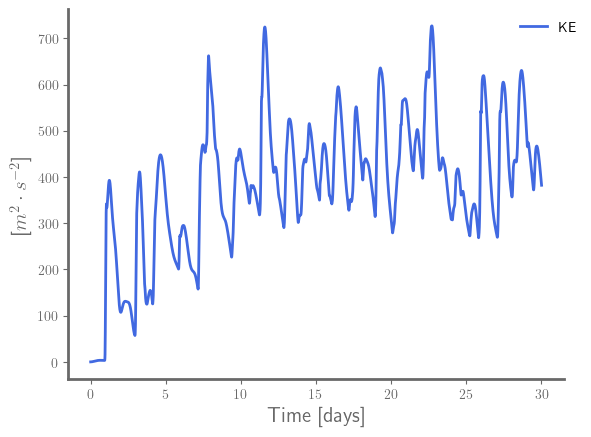

In [10]:
plt.figure()
plt.xlabel('Time [days]', fontsize = 15, color = 'dimgray')
plt.ylabel('[$m^2\cdot s^{-2}$]', fontsize = 15, color = 'dimgray')
plt.plot(time_list/days, kinetic, label = 'KE', color = 'royalblue', lw = 2)
# plt.plot(time_list, potential_g, label= 'Gravitational PE', color = 'darkorange')
# plt.plot(time_list, potential_q, label= 'Moist PE', color = 'firebrick')
# plt.plot(time_list, TE, label= 'Total', color = 'k')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('dimgray')
ax.tick_params(axis='both', colors='dimgray')  
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1))
# plt.yscale('log')
# plt.ylim(0, 5)
plt.savefig(path + '/KE__MJO.png', dpi = 200)

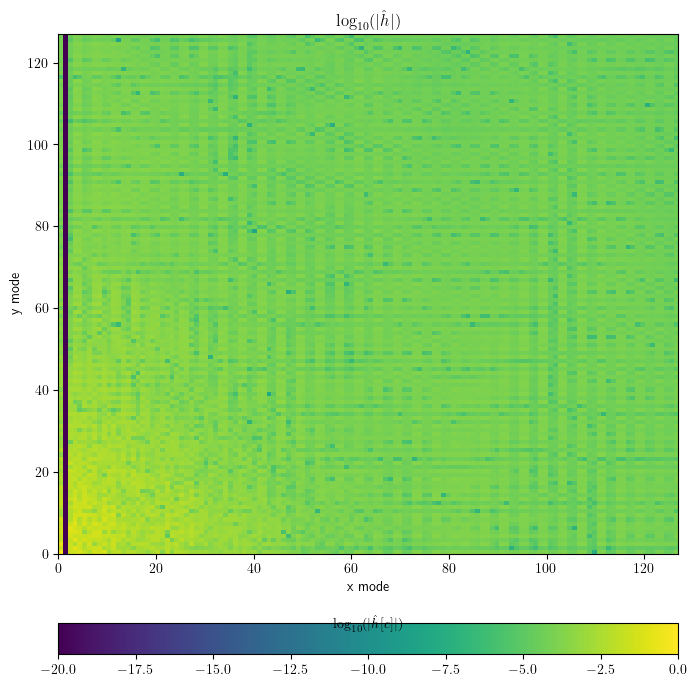

In [ ]:

k_x = dist.local_grid(x_basis, scale = 1) 

Nx_local = x_basis.size

ind  =-1
final_h_c = h_s[ind]
final_ux_c = ux_s[ind]
final_uy_c = uy_s[ind]

h_power_spectrum = np.sum(np.abs(final_h_c)**2, axis=1)
kinetic_energy_spectrum = 0.5 * np.sum(np.abs(final_ux_c)**2 + np.abs(final_uy_c)**2, axis=1)

epsilon = 1e-30 
h_log_mag = np.log10(np.abs(final_h_c) + epsilon)

x_modes = np.arange(Nx) 
y_modes = np.arange(Ny) 

fig_2d, ax_2d = plt.subplots(figsize=(8, 9))

vmin_val = -20
vmax_val = 0

im = ax_2d.imshow(h_log_mag.T,origin='lower', cmap='viridis',  aspect='auto',   vmin=vmin_val,  vmax=vmax_val,  extent=[x_modes.min(), x_modes.max(), y_modes.min(), y_modes.max()])

ax_2d.set_xlabel('x mode')
ax_2d.set_ylabel('y mode')
ax_2d.set_title(r'$\log_{10}(|\hat{h}|)$')

cbar = fig_2d.colorbar(im, ax=ax_2d, orientation='horizontal', pad=0.1)
cbar.set_label(r'$\log_{10}(|\hat{h}[c]|)$', rotation=0, labelpad=15)
cbar.ax.xaxis.set_label_coords(0.5, 1.25) 
plt.savefig(path + '/spectrum.png')
plt.show()

In [11]:
# # %%notify -m "Animation Complete -- MJO_VALLIS"
# from datetime import datetime
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# import numpy as np
# h_data = np.array(h_list)
# t_data = np.array(t_list)
# C_data = np.array(q_list)

# frame_skip = 10
# h_anim = h_data[::frame_skip]
# C_anim = C_data[::frame_skip]
# t_anim = t_data[::frame_skip]
# n_frames = len(t_anim)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# h0 = h_anim[0].T
# C0 = C_anim[0].T
# h_vmax0 = np.max(np.abs(h0))
# im1 = ax1.imshow(h0, extent=[xmin, xmax, ymin, ymax], origin='lower',   cmap='RdBu_r', vmin=-h_vmax0, vmax=h_vmax0)
# cbar1 = fig.colorbar(im1, ax=ax1, label='Height (h)')
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')

# C_vmin0, C_vmax0 = np.min(C0), np.max(C0)
# im2 = ax2.imshow(C0,extent=[xmin, xmax, ymin, ymax],  origin='lower',cmap='Blues', vmin=C_vmin0, vmax=C_vmax0)
# cbar2 = fig.colorbar(im2, ax=ax2, label='Rainfall (C)')
# ax2.set_xlabel('x')

# title = fig.suptitle(f'Time = {t_anim[0]/(24*60*60):.2f} Days')

# plt.tight_layout()
# def animate(i):
#     h_frame = h_anim[i].T
#     C_frame = C_anim[i].T

#     im1.set_data(h_frame)
#     h_vmax = np.max(np.abs(h_frame))
#     if h_vmax < 1e-12: 
#         h_vmax = 1e-12 
#     im1.set_clim(-h_vmax, h_vmax)
    
#     cbar1.update_normal(im1)   

#     C_vmin, C_vmax = np.min(C_frame), np.max(C_frame)
#     if C_vmax - C_vmin < 1e-12:
#         C_vmin -= 1e-12
#         C_vmax += 1e-12
#     im2.set_clim(C_vmin, C_vmax)
#     cbar2.update_normal(im2)
#     title.set_text(f'Time = {t_anim[i]/(24*60*60):.2f} Days')

#     return im1, im2, title 

# ani = FuncAnimation(fig, animate, frames=n_frames, blit=False)
# outname = f'/Users/luitbald/CODE/movies/MJO/MJO_VALLIS_TESTING_{alpha}a_{gamma}g_{datetime.now().strftime("%y-%m-%d %H:%M")}.mp4'
# ani.save(outname, writer='ffmpeg', fps=20, dpi=50)

# # requests.post("https://ntfy.sh/LEOPIDOLITE_SIMS", data="ANIMATION COMPLETE".encode('utf-8'))


2025-12-01 13:40:13,671 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>
frame 0 out of 51
frame 0 out of 51
2025-12-01 13:40:13,682 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the sans-serif fontfamily in rcParams. Using default.
2025-12-01 13:40:13,683 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the sans-serif fontfamily in rcParams. Using default.
2025-12-01 13:40:13,685 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the sans-serif fontfamily in rcParams. Using default.
2025-12-01 13:40:13,687 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the sans-serif fontfamily in rcParams. Using default.
2025-12-01 13:40:13,689 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the sans-serif fontfamily in rcParams. Using default.
2025-12-01 13:40:13,691 matplotlib.texmanager 0/1 INFO :: No LaTeX-compatible font found for the sans-serif

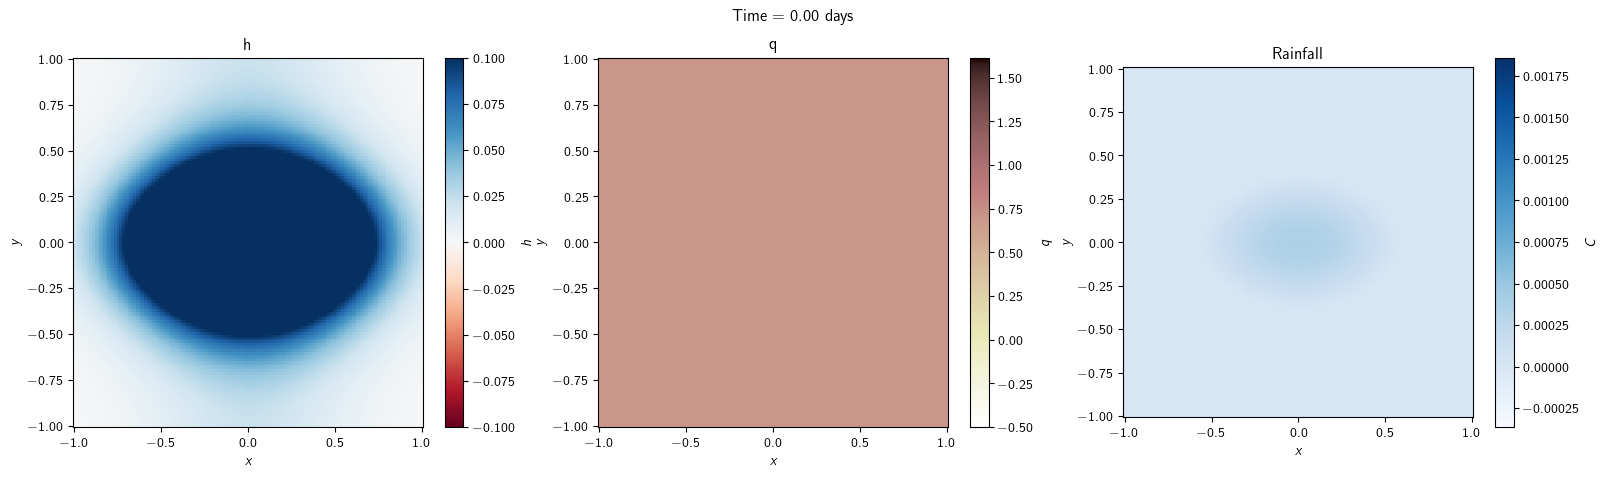

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import h5py
import os
import pandas as pd
import time

start_time = time.time()

import matplotlib.colors as mcolors

def read_files():
    dirpath = filename 
    df = pd.DataFrame()
    for filepath in os.listdir(dirpath):
        if filepath.endswith(".h5"):
            file = h5py.File(dirpath+"/"+filepath, mode="r")
            current_file_df = pd.DataFrame()
            for task in file['tasks']:
                current_file_df[task] = np.array(file['tasks'][task]).tolist()
            df = pd.concat([df,current_file_df],ignore_index=True)
    return df


def series_to_ndarray(series):
    if series.size == 0:
        return np.array([])
    element_shape = np.array(series[0]).shape
    shape = np.concatenate([[series.size],element_shape])
    ndarray = np.zeros(shape)
    for i in range(shape[0]):
        ndarray[i] = np.array(series[i])
    return ndarray

def get_max_u(data):
    umax = 0.0
    u = data['U']
    for i in range(u.shape[0]):
        u_current = np.array(u[i]).flatten()
        umax_current = np.max(u_current)
        if umax_current > umax:
            umax = umax_current
    return umax


def get_h_lims(data):
    hmin = 0.0
    hmax = 0.0
    h = data['h']
    for i in range(h.shape[0]):
        h_current = np.array(h[i]).flatten()        
        hmin_current = np.min(h_current)
        hmax_current = np.max(h_current)
        if hmin_current < hmin:
            hmin = hmin_current
        if hmax_current > hmax:
            hmax = hmax_current
    return hmin, hmax


def get_q_lims(data):
    qmin = 0.0
    qmax = 0.0
    q = data['q']
    for i in range(q.shape[0]):
        q_current = np.array(q[i]).flatten()        
        qmin_current = np.min(q_current)
        qmax_current = np.max(q_current)
        if qmin_current < qmin:
            qmin = qmin_current
        if qmax_current > qmax:
            qmax = qmax_current
    return qmin, qmax


def get_C_lims(data):
    Cmin = 0.0
    Cmax = 0.0
    C = data['C']
    for i in range(C.shape[0]):
        C_current = np.array(C[i]).flatten()        
        Cmin_current = np.min(C_current)
        Cmax_current = np.max(C_current)
        if Cmin_current < Cmin:
            Cmin = Cmin_current
        if Cmax_current > Cmax:
            Cmax = Cmax_current
    return Cmin, Cmax


def update_u_h_frame(frame,up,hp,ux,uy,h,res):
    # ux_current = ux[frame][::res,::res]
    # uy_current = uy[frame][::res,::res]
    h_current = h[frame][::res,::res]
    hp.set_array(np.transpose(h_current).flatten())
    # up.set_UVC(np.transpose(ux_current), np.transpose(uy_current))
    return up,hp


def update_scalar_frame(frame,val_plot,val,res):
    val_current = val[frame][::res,::res]
    val_plot.set_array(np.transpose(val_current).flatten())
    return val_plot,


def update_frame_combined(frame,up,hp,qp,Cp,ux,uy,h,q,C,res):
    if frame % 100 == 0:
        n = len(ux)
        print("frame {} out of {}".format(frame,n))
    up,hp = update_u_h_frame(frame,up,hp,ux,uy,h,res)
    qp, = update_scalar_frame(frame,qp,q,res)
    Cp, = update_scalar_frame(frame,Cp,C,res)
    days = frame * (solver.stop_sim_time / len(ux)) / (24*60*60)
    hp.figure.suptitle(f"Time = {days:.2f} days")

    return up,hp,qp,Cp


def plot_combined(data):
    umax = get_max_u(data)
    hmin, hmax = get_h_lims(data)
    qmin, qmax = get_q_lims(data)
    Cmin, Cmax = get_C_lims(data)
    res = 5 # plotting resolution. n/res points are plotted

    u = series_to_ndarray(data['U'])
    ux = u[:,0,:,:]
    uy = u[:,1,:,:]
    h = series_to_ndarray(data['h'])
    q = series_to_ndarray(data['q'])
    C = series_to_ndarray(data['C'])
    
    nframes, nx, ny = np.array(ux).shape
    res = 1 # plotting resolution
    xmin, xmax = -1, 1
    ymin, ymax = -1, 1
    xgrid = np.linspace(xmin,xmax,nx)[::res]
    ygrid = np.linspace(ymin,ymax,ny)[::res]
    X,Y = np.meshgrid(xgrid,ygrid)

    fig, (ax1,ax2,ax3) = plt.subplots(1,3)

    hp = ax1.pcolormesh(X,Y,np.zeros_like(X), cmap='RdBu')
    up = None#ax1.quiver(X,Y,np.zeros_like(X),np.zeros_like(X)) #, scale=1.1/(umax+1e-8)
    plt.gca().set_aspect("equal")
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$y$")
    plt.colorbar(hp,label="$h$")
    ax1.set_title("h")

    qp = ax2.pcolormesh(X,Y,np.zeros_like(X),vmin=qmin,vmax=qmax, cmap='pink_r')
    plt.gca().set_aspect("equal")
    ax2.set_xlabel("$x$")
    ax2.set_ylabel("$y$")
    plt.colorbar(qp,label="$q$")
    ax2.set_title("q")

    Cp = ax3.pcolormesh(X,Y,np.zeros_like(X),vmin=Cmin,vmax=Cmax,cmap='Blues')
    plt.gca().set_aspect("equal")
    ax3.set_xlabel("$x$")
    ax3.set_ylabel("$y$")
    plt.colorbar(Cp,label="$C$")
    ax3.set_title("Rainfall")

    fig.set_figwidth(3 * fig.get_size_inches()[0])

    frameslist = np.arange(nframes,step=5)
    anim = FuncAnimation(fig, update_frame_combined, fargs=(up,hp,qp,Cp,ux,uy,h,q,C,res), frames=frameslist, blit=False, repeat=False)
    return anim





#####################################################

# make plots

data = read_files()
combined_anim = plot_combined(data)
combined_anim.save(path +"/MJO_combined.gif", writer=PillowWriter(fps=5))






#####################################################

# stop time

stop_time = time.time()

print("time elapsed: ", stop_time - start_time, " seconds")

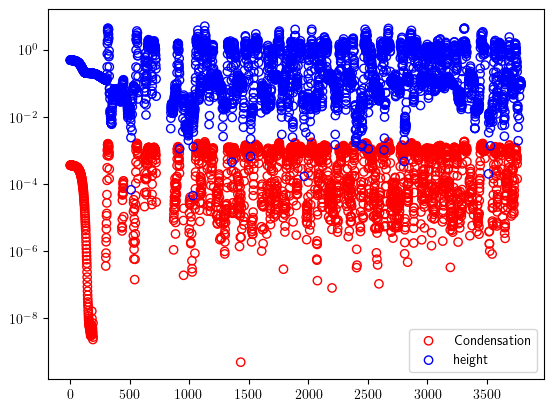

In [12]:
C_max = [np.max(C_list[i]) for i in range(len(C_list))]
h_max = [np.max(h_list[i]) for i in range(len(h_list))]
plt.scatter(np.arange(len(C_list)-12), C_max[:-12], edgecolor = 'r', facecolors = 'none', label = 'Condensation')
plt.scatter(np.arange(len(h_list)-12), h_max[:-12], edgecolor = 'b',facecolors = 'none', label = 'height')
plt.legend()
plt.yscale('log')
plt.savefig(path+'/hCtimeseries.png')